In [1]:
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import random
import rl_utils

In [2]:
!git clone https://github.com/boyu-ai/multiagent-particle-envs.git --quiet
!pip install -e multiagent-particle-envs
import sys
sys.path.append("multiagent-particle-envs")
# 由于multiagent-pariticle-env底层的实现有一些版本问题,因此gym需要改为可用的版本
!pip install --upgrade gym==0.10.5 -q
import gym
from multiagent.environment import MultiAgentEnv
import multiagent.scenarios as scenarios


def make_env(scenario_name):
    # 从环境文件脚本中创建环境
    scenario = scenarios.load(scenario_name + ".py").Scenario()
    world = scenario.make_world()
    env = MultiAgentEnv(world, scenario.reset_world, scenario.reward,
                        scenario.observation)
    return env

fatal: destination path 'multiagent-particle-envs' already exists and is not an empty directory.
Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple
Obtaining file:///mnt/0dbb253c-43fe-4ab1-99c3-d9faf5863008/Hands-on-RL/multiagent-particle-envs
  Preparing metadata (setup.py) ... done
  Attempting uninstall: multiagent
    Found existing installation: multiagent 0.0.1
    Uninstalling multiagent-0.0.1:
      Successfully uninstalled multiagent-0.0.1
  DEPRECATION: Legacy editable install of multiagent==0.0.1 from file:///mnt/0dbb253c-43fe-4ab1-99c3-d9faf5863008/Hands-on-RL/multiagent-particle-envs (setup.py develop) is deprecated. pip 25.0 will enforce this behaviour change. A possible replacement is to add a pyproject.toml or enable --use-pep517, and use setuptools >= 64. If the resulting installation is not behaving as expected, try using --config-settings editable_mode=compat. Please consult the setuptools documentation for more information. Discussion can be found at https

In [3]:
def onehot_from_logits(logits, eps=0.01):
    ''' 生成最优动作的独热（one-hot）形式 '''
    argmax_acs = (logits == logits.max(1, keepdim=True)[0]).float()
    # 生成随机动作,转换成独热形式
    rand_acs = torch.autograd.Variable(torch.eye(logits.shape[1])[[
        np.random.choice(range(logits.shape[1]), size=logits.shape[0])
    ]],
                                       requires_grad=False).to(logits.device)
    # 通过epsilon-贪婪算法来选择用哪个动作
    return torch.stack([
        argmax_acs[i] if r > eps else rand_acs[i]
        for i, r in enumerate(torch.rand(logits.shape[0]))
    ])


def sample_gumbel(shape, eps=1e-20, tens_type=torch.FloatTensor):
    """从Gumbel(0,1)分布中采样"""
    U = torch.autograd.Variable(tens_type(*shape).uniform_(),
                                requires_grad=False)
    return -torch.log(-torch.log(U + eps) + eps)


def gumbel_softmax_sample(logits, temperature):
    """ 从Gumbel-Softmax分布中采样"""
    y = logits + sample_gumbel(logits.shape, tens_type=type(logits.data)).to(
        logits.device)
    return F.softmax(y / temperature, dim=1)


def gumbel_softmax(logits, temperature=1.0):
    """从Gumbel-Softmax分布中采样,并进行离散化"""
    y = gumbel_softmax_sample(logits, temperature)
    y_hard = onehot_from_logits(y)
    y = (y_hard.to(logits.device) - y).detach() + y
    # 返回一个y_hard的独热量,但是它的梯度是y,我们既能够得到一个与环境交互的离散动作,又可以
    # 正确地反传梯度
    return y

In [4]:
class TwoLayerFC(torch.nn.Module):
    def __init__(self, num_in, num_out, hidden_dim):
        super().__init__()
        self.fc1 = torch.nn.Linear(num_in, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = torch.nn.Linear(hidden_dim, num_out)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


class DDPG:
    ''' DDPG算法 '''
    def __init__(self, state_dim, action_dim, critic_input_dim, hidden_dim,
                 actor_lr, critic_lr, device):
        self.actor = TwoLayerFC(state_dim, action_dim, hidden_dim).to(device)
        self.target_actor = TwoLayerFC(state_dim, action_dim,
                                       hidden_dim).to(device)
        self.critic = TwoLayerFC(critic_input_dim, 1, hidden_dim).to(device)
        self.target_critic = TwoLayerFC(critic_input_dim, 1,
                                        hidden_dim).to(device)
        self.target_critic.load_state_dict(self.critic.state_dict())
        self.target_actor.load_state_dict(self.actor.state_dict())
        self.actor_optimizer = torch.optim.Adam(self.actor.parameters(),
                                                lr=actor_lr)
        self.critic_optimizer = torch.optim.Adam(self.critic.parameters(),
                                                 lr=critic_lr)

    def take_action(self, state, explore=False):
        action = self.actor(state)
        if explore:
            action = gumbel_softmax(action)
        else:
            action = onehot_from_logits(action)
        return action.detach().cpu().numpy()[0]

    def soft_update(self, net, target_net, tau):
        for param_target, param in zip(target_net.parameters(),
                                       net.parameters()):
            param_target.data.copy_(param_target.data * (1.0 - tau) +
                                    param.data * tau)

In [5]:
class MADDPG:
    def __init__(self, env, device, actor_lr, critic_lr, hidden_dim,
                 state_dims, action_dims, critic_input_dim, gamma, tau):
        self.agents = []
        for i in range(len(env.agents)):
            self.agents.append(
                DDPG(state_dims[i], action_dims[i], critic_input_dim,
                     hidden_dim, actor_lr, critic_lr, device))
        self.gamma = gamma
        self.tau = tau
        self.critic_criterion = torch.nn.MSELoss()
        self.device = device

    @property
    def policies(self):
        return [agt.actor for agt in self.agents]

    @property
    def target_policies(self):
        return [agt.target_actor for agt in self.agents]

    def take_action(self, states, explore):
        states = [
            torch.tensor([states[i]], dtype=torch.float, device=self.device)
            for i in range(len(env.agents))
        ]
        return [
            agent.take_action(state, explore)
            for agent, state in zip(self.agents, states)
        ]

    def update(self, sample, i_agent):
        obs, act, rew, next_obs, done = sample
        cur_agent = self.agents[i_agent]

        cur_agent.critic_optimizer.zero_grad()
        all_target_act = [
            onehot_from_logits(pi(_next_obs))
            for pi, _next_obs in zip(self.target_policies, next_obs)
        ]
        target_critic_input = torch.cat((*next_obs, *all_target_act), dim=1)
        target_critic_value = rew[i_agent].view(
            -1, 1) + self.gamma * cur_agent.target_critic(
                target_critic_input) * (1 - done[i_agent].view(-1, 1))
        critic_input = torch.cat((*obs, *act), dim=1)
        critic_value = cur_agent.critic(critic_input)
        critic_loss = self.critic_criterion(critic_value,
                                            target_critic_value.detach())
        critic_loss.backward()
        cur_agent.critic_optimizer.step()

        cur_agent.actor_optimizer.zero_grad()
        cur_actor_out = cur_agent.actor(obs[i_agent])
        cur_act_vf_in = gumbel_softmax(cur_actor_out)
        all_actor_acs = []
        for i, (pi, _obs) in enumerate(zip(self.policies, obs)):
            if i == i_agent:
                all_actor_acs.append(cur_act_vf_in)
            else:
                all_actor_acs.append(onehot_from_logits(pi(_obs)))
        vf_in = torch.cat((*obs, *all_actor_acs), dim=1)
        actor_loss = -cur_agent.critic(vf_in).mean()
        actor_loss += (cur_actor_out**2).mean() * 1e-3
        actor_loss.backward()
        cur_agent.actor_optimizer.step()

    def update_all_targets(self):
        for agt in self.agents:
            agt.soft_update(agt.actor, agt.target_actor, self.tau)
            agt.soft_update(agt.critic, agt.target_critic, self.tau)

In [6]:
num_episodes = 5000
episode_length = 25  # 每条序列的最大长度
buffer_size = 100000
hidden_dim = 64
actor_lr = 1e-2
critic_lr = 1e-2
gamma = 0.95
tau = 1e-2
batch_size = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
update_interval = 100
minimal_size = 4000

env_id = "simple_adversary"
env = make_env(env_id)
replay_buffer = rl_utils.ReplayBuffer(buffer_size)

state_dims = []
action_dims = []
for action_space in env.action_space:
    action_dims.append(action_space.n)
for state_space in env.observation_space:
    state_dims.append(state_space.shape[0])
critic_input_dim = sum(state_dims) + sum(action_dims)

maddpg = MADDPG(env, device, actor_lr, critic_lr, hidden_dim, state_dims,
                action_dims, critic_input_dim, gamma, tau)

In [7]:
def evaluate(env_id, maddpg, n_episode=10, episode_length=25):
    # 对学习的策略进行评估,此时不会进行探索
    env = make_env(env_id)
    returns = np.zeros(len(env.agents))
    for _ in range(n_episode):
        obs = env.reset()
        for t_i in range(episode_length):
            actions = maddpg.take_action(obs, explore=False)
            obs, rew, done, info = env.step(actions)
            rew = np.array(rew)
            returns += rew / n_episode
    return returns.tolist()


return_list = []  # 记录每一轮的回报（return）
total_step = 0
for i_episode in range(num_episodes):
    state = env.reset()
    # ep_returns = np.zeros(len(env.agents))
    for e_i in range(episode_length):
        actions = maddpg.take_action(state, explore=True)
        next_state, reward, done, _ = env.step(actions)
        replay_buffer.add(state, actions, reward, next_state, done)
        state = next_state

        total_step += 1
        if replay_buffer.size(
        ) >= minimal_size and total_step % update_interval == 0:
            sample = replay_buffer.sample(batch_size)

            def stack_array(x):
                rearranged = [[sub_x[i] for sub_x in x]
                              for i in range(len(x[0]))]
                return [
                    torch.FloatTensor(np.vstack(aa)).to(device)
                    for aa in rearranged
                ]

            sample = [stack_array(x) for x in sample]
            for a_i in range(len(env.agents)):
                maddpg.update(sample, a_i)
            maddpg.update_all_targets()
    if (i_episode + 1) % 100 == 0:
        ep_returns = evaluate(env_id, maddpg, n_episode=100)
        return_list.append(ep_returns)
        print(f"Episode: {i_episode+1}, {ep_returns}")

# Episode: 100, [-139.85078880125366, 24.84409588589504, 24.84409588589504]

# /content/rl_utils.py:17: VisibleDeprecationWarning: Creating an ndarray from ragged
# nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different
# lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=
# object' when creating the ndarray
#   return np.array(state), action, reward, np.array(next_state), done

# Episode: 200, [-105.11447331630691, -4.667816632926483, -4.667816632926483]
# Episode: 300, [-31.04371751870054, 2.367667721218739, 2.367667721218739]
# Episode: 400, [-25.856803405338162, -1.6019954659169862, -1.6019954659169862]
# Episode: 500, [-14.863629584466256, -6.493559215483058, -6.493559215483058]
# Episode: 600, [-11.753253499724337, 1.1278364537452759, 1.1278364537452759]
# Episode: 700, [-12.55948132966949, 0.36995365890528387, 0.36995365890528387]
# Episode: 800, [-11.204469505024559, 5.799833097835371, 5.799833097835371]
# Episode: 900, [-12.793323601010943, 7.0357387891514716, 7.0357387891514716]
# Episode: 1000, [-9.731828562147946, 5.203205531782827, 5.203205531782827]
# Episode: 1100, [-8.510131349426718, 5.2461119857635135, 5.2461119857635135]
# Episode: 1200, [-9.585692738161287, 6.777259476592237, 6.777259476592237]
# Episode: 1300, [-9.826005870972006, 7.207743730178556, 7.207743730178556]
# Episode: 1400, [-8.566589499183216, 6.2620796176791, 6.2620796176791]
# Episode: 1500, [-8.543261572521422, 5.8545569515458755, 5.8545569515458755]
# Episode: 1600, [-9.719611039111387, 6.136607469223544, 6.136607469223544]
# Episode: 1700, [-8.2925932025312, 5.435361693227948, 5.435361693227948]
# Episode: 1800, [-8.959067279108076, 5.990426636679429, 5.990426636679429]
# Episode: 1900, [-8.8242500783286, 5.307928537097473, 5.307928537097473]
# Episode: 2000, [-8.20281209652912, 5.689542567717828, 5.689542567717828]
# Episode: 2100, [-9.04772055064216, 5.583820408577938, 5.583820408577938]
# Episode: 2200, [-8.50059251561189, 5.6745737134871215, 5.6745737134871215]
# Episode: 2300, [-6.878826441166284, 4.451387010062865, 4.451387010062865]
# Episode: 2400, [-9.324710297045764, 5.414272587118738, 5.414272587118738]
# Episode: 2500, [-8.215515333155677, 5.0714473072251085, 5.0714473072251085]
# Episode: 2600, [-9.710948754211286, 5.945957102784014, 5.945957102784014]
# Episode: 2700, [-6.95987837179912, 4.306175766599912, 4.306175766599912]
# Episode: 2800, [-7.69945047297023, 4.63572107199487, 4.63572107199487]
# Episode: 2900, [-7.640228784974167, 5.129701244255248, 5.129701244255248]
# Episode: 3000, [-7.33452401443051, 4.234568124813538, 4.234568124813538]
# Episode: 3100, [-7.561209771041727, 4.551318252296591, 4.551318252296591]
# Episode: 3200, [-7.303825192093116, 4.1751459368803525, 4.1751459368803525]
# Episode: 3300, [-7.4085041799390225, 4.324439976487989, 4.324439976487989]
# Episode: 3400, [-8.831540597437234, 5.095912768930884, 5.095912768930884]
# Episode: 3500, [-7.909255169344246, 4.814617328955552, 4.814617328955552]
# Episode: 3600, [-8.102049625513107, 4.218137021221713, 4.218137021221713]
# Episode: 3700, [-7.124044426425797, 4.22171591046473, 4.22171591046473]
# Episode: 3800, [-9.855226095181644, 5.559444947358021, 5.559444947358021]
# Episode: 3900, [-8.112882872673746, 4.601425710926074, 4.601425710926074]
# Episode: 4000, [-7.7353843779903855, 4.842239161334104, 4.842239161334104]
# Episode: 4100, [-7.877527887061531, 4.593953921896876, 4.593953921896876]
# Episode: 4200, [-7.401751185392445, 4.52101055148277, 4.52101055148277]
# Episode: 4300, [-8.233404140017905, 4.713286609882572, 4.713286609882572]
# Episode: 4400, [-8.653939326472079, 5.184954272702421, 5.184954272702421]
# Episode: 4500, [-9.767723118921353, 6.570082634111054, 6.570082634111054]
# Episode: 4600, [-9.30060260689829, 5.242836047978754, 5.242836047978754]
# Episode: 4700, [-8.964009029648428, 4.901113456984634, 4.901113456984634]
# Episode: 4800, [-10.22982114177131, 5.669039384469422, 5.669039384469422]
# Episode: 4900, [-10.568961308877448, 4.479337463298422, 4.479337463298422]
# Episode: 5000, [-8.700993807143094, 4.4632810497979705, 4.4632810497979705]

/tmp/ipykernel_1307744/259114891.py:24: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  torch.tensor([states[i]], dtype=torch.float, device=self.device)


Episode: 100, [-136.75666604330982, 10.197104726169705, 10.197104726169705]
Episode: 200, [-37.241004720100285, 2.135472783292243, 2.135472783292243]
Episode: 300, [-24.17261059608891, -3.8773964727830954, -3.8773964727830954]
Episode: 400, [-21.743158542049027, -2.941176725190266, -2.941176725190266]
Episode: 500, [-12.599189448047166, 2.654937419275587, 2.654937419275587]
Episode: 600, [-13.913008756121492, 7.231624312948203, 7.231624312948203]
Episode: 700, [-11.306466221082177, 6.225709628690222, 6.225709628690222]
Episode: 800, [-11.044908146777157, 7.388111093904507, 7.388111093904507]
Episode: 900, [-9.565832949754423, 7.256587536599818, 7.256587536599818]
Episode: 1000, [-11.177167158674592, 8.253388328370232, 8.253388328370232]
Episode: 1100, [-7.887309302296757, 5.402154317506838, 5.402154317506838]
Episode: 1200, [-8.952462089830057, 6.4973289612553895, 6.4973289612553895]
Episode: 1300, [-9.286559941632538, 6.202272493769537, 6.202272493769537]
Episode: 1400, [-9.2962893397

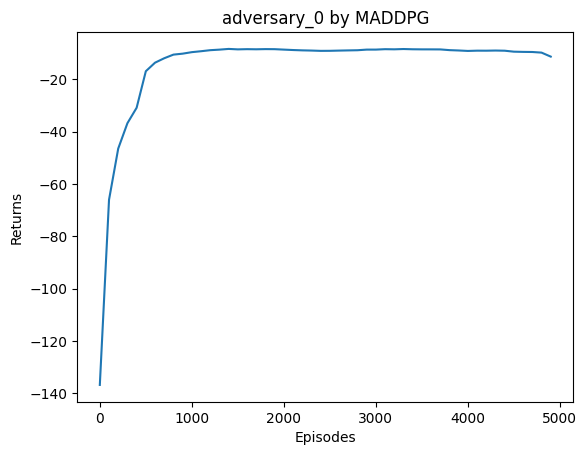

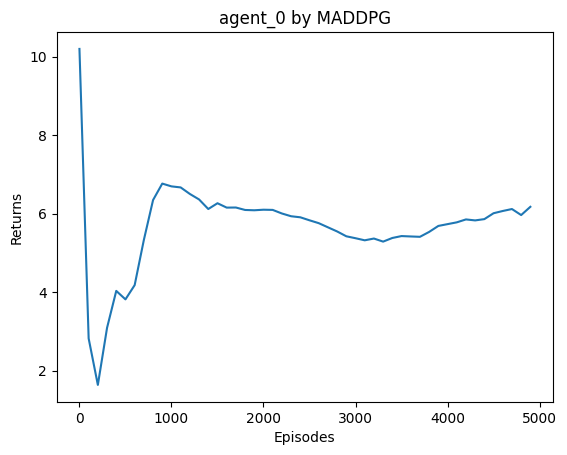

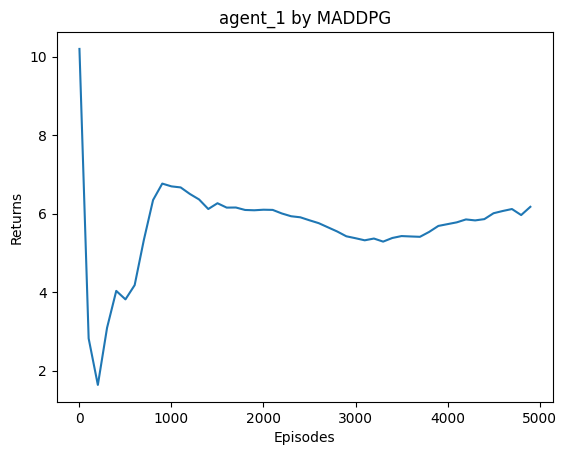

In [8]:
return_array = np.array(return_list)
for i, agent_name in enumerate(["adversary_0", "agent_0", "agent_1"]):
    plt.figure()
    plt.plot(
        np.arange(return_array.shape[0]) * 100,
        rl_utils.moving_average(return_array[:, i], 9))
    plt.xlabel("Episodes")
    plt.ylabel("Returns")
    plt.title(f"{agent_name} by MADDPG")